<a href="https://colab.research.google.com/github/1o0ko/gumbel-softmax/blob/master/Gumbel_Softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gumbel Distribution

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [0]:
N = 10**6
bins = 10

In [0]:
u = np.random.random((N))

Text(0.5,1,'Uniform distribution')

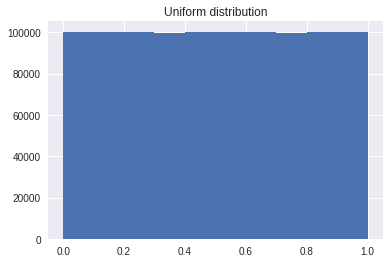

In [4]:
plt.hist(u, bins=bins);
plt.title("Uniform distribution")

In [0]:
g = -np.log(-np.log(u))

Text(0.5,1,'Gumbel distribution')

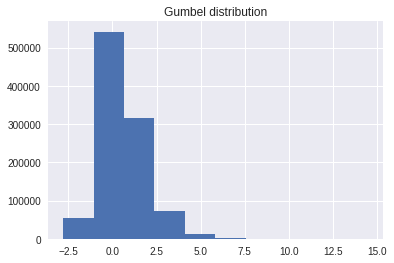

In [6]:
plt.hist(g, bins=bins);
plt.title("Gumbel distribution")

# Discrete Sampling

Goal: Sampling from a discrete distribution parametrized by $K$ unnormalized log-probabilities $\alpha_k$:

$$
    \pi_k =\frac{1}{z} \exp(\alpha_k),  \quad \textrm{where} \, z=\sum_j^K \exp(x_j)
$$

# The Gumbel Distribution tidck

Let $X$ be a discrete random variable with $P(X=k)\propto \alpha_k$ random variable and let $\{G_k\}_{k\leq K}$
be an i.i.d sequence of standard Gumbel random variables. 

Then:
$$
    X = \arg\max_k(\log \alpha_k + G_k)
$$

The algorithm
* draw Gumbel noise by transforming uniform samples
* add the noise to the $\log \alpha_k$
* take value k that produces the maximum

In [0]:
def gumbel(shape, eps=1e-10):
    """ Sample from Gumbel(0, 1)"""
    u =  np.random.random(shape)
    g = -np.log(-np.log(u + eps) + eps)
    return g
    
def gumbel_max_sample(x, is_prob=False):
    """ Draw a sample from P(X=k) prop x_k """
    if is_prob:
        x = np.log(x)
        
    g = gumbel(shape=x.shape)
    return (g + x).argmax(axis=0)

# Relaxing the discretness

The main idea

* Any discrete random variable can be always expressed as one hot-vector
* the convex hull of the set of one-hot vector is the probability simplex:
$$
\Delta^{K-1} = \big\{ x \in R^K_+, \, \sum_{k=1}^K x_k = 1 \big\}
$$

Therefore, a natural way to extend (or ‘relax’) a discrete random variables is by allowing it to take values in the *probability simplex*. We can can consider a soft-max map, to extend the values of a discrete random variable

$$
    f_\tau (x)_k = \frac{\exp(x_k / \tau)}{\sum_{k=1}^K\exp(x_k / \tau)}
$$

In [0]:
def softmax(X, temperature = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats. 
    temperature (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the 
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """
    y = np.atleast_2d(X)

    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    y = y / float(temperature)
    y = y - np.expand_dims(np.max(y, axis = axis), axis)
    y = np.exp(y)

    # take the sum along the specified axis
    p = y / np.expand_dims(np.sum(y, axis = axis), axis)

    if len(X.shape) == 1: 
        p = p.flatten()

    return p

In [0]:
def gumbel_softmax_sample(logits, temperature=1): 
    """ Draw a sample from the Gumbel-Softmax distribution"""
    y = logits + gumbel(np.shape(logits))
    return softmax(y, temperature=temperature)

# An example sampling

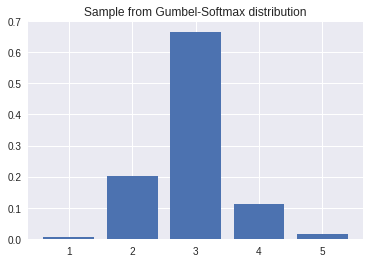

In [10]:
logits = [1, 4, 5, 1, 2]
classes = range(1, len(logits) + 1)
sample = gumbel_softmax_sample(logits, temperature=1)

plt.title("Sample from Gumbel-Softmax distribution")
plt.bar(classes, sample);

# Gumbel-Softmax in PyTorch

In [11]:
! pip3 install torch torchvision
! pip3 install pillow

In [0]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

def sample_gumbel(shape, eps=1e-20, device='cuda'):
    ''' Sample from Gumbel(0, 1) ''' 
    U = torch.rand(shape).to(device)    
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    ''' Draw a sample from the Gumbel-Softmax distribution ''' 
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False):
    '''Sample from the Gumbel-Softmax distribution and optionally discretize.
    
    Args:
      logits: [batch_size, n_class] unnormalized log-probs
      temperature: non-negative scalar
      hard: if True, take argmax, but differentiate w.r.t. soft sample y
    
    Returns:
      [batch_size, n_class] sample from the Gumbel-Softmax distribution.
      If hard=True, then the returned sample will be one-hot, otherwise it will
      be a probabilitiy distribution that sums to 1 across classes
    '''
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
      shape = y.size()
      _, ind = y.max(dim=-1)
      y_hard = torch.zeros_like(y).view(-1, shape[-1])
      y_hard.scatter_(1, ind.view(-1, 1), 1)
      y_hard = y_hard.view(*shape)
      y =  (y_hard - y).detach() + y      
    
    return y


In [0]:
logits = torch.Tensor([1, 1.3]).cuda()
classes = range(1, len(logits) + 1)
sample = gumbel_softmax(logits, temperature=1, hard=False)

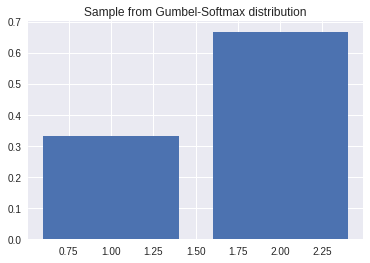

In [107]:
plt.title("Sample from Gumbel-Softmax distribution")
plt.bar(classes, sample);

## Data

In [0]:
import os

directory = '/content/results/'
if not os.path.exists(directory):
  os.makedirs(directory)

In [0]:
import torch.utils.data

from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [0]:
device = torch.device("cuda")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

## Binary-VAE

In [0]:
ANNEAL_RATE = 0.00003


class BinaryVAE(nn.Module):
    def __init__(self, latent_dim):
        super(BinaryVAE, self).__init__()
        
        # meta info
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
          nn.Linear(784, 512),
          nn.ReLU(True),
          nn.Linear(512, 256),
          nn.ReLU(True),
          nn.Linear(256, latent_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim * 2, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )
      

    def get_codes(self, x, temp):
        logits = self.encoder(x.view(-1, 784))
        logits = logits.view(-1, self.latent_dim, 2)
        
        codes = gumbel_softmax(logits, temp, hard=True)
        codes = codes[:,:, 0] # take the first column of the binary variable
        
        return codes
      
    def forward(self, x, temp, hard):
 
        q = self.encoder(x.view(-1, 784))
        q_y = q.view(-1, self.latent_dim, 2)
        

        z = gumbel_softmax(q_y, temp, hard)
        z = z.view(-1, self.latent_dim * 2)
        
        x_recon = self.decoder(z)
        
        q_y = F.softmax(q_y, dim=-1).reshape(*q.size())

        return x_recon, q_y



def loss_function(recon_x, x, q_y):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False) / x.shape[0]

    log_ratio = torch.log(q_y * 2 + 1e-20)
    KLD = torch.sum(q_y * log_ratio, dim=-1).mean()

    return BCE + KLD


  
def train(epoch, model, train_loader, optimizer, temp, cuda=True, hard=False):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if cuda:
            data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, q_y = model(data, temp, hard)
        
        loss = loss_function(recon_batch, data, q_y)
        loss.backward()
        
        train_loss += loss.item() * len(data)
        optimizer.step()
        
        if batch_idx % 100 == 1:
            temp = np.maximum(temp * np.exp(-ANNEAL_RATE * batch_idx), temp_min)

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       loss.item()))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))



def test(epoch, model, test_loader, temp, cuda=True, hard=False):
    model.eval()
    test_loss = 0
  
    for i, (data, _) in enumerate(test_loader):
        if cuda:
          data = data.cuda()
  
        recon_batch, qy = model(data, temp, hard)
        test_loss += loss_function(recon_batch, data, qy).item() * len(data)
        
        if i % 100 == 1:
            temp = np.maximum(temp * np.exp(-ANNEAL_RATE * i), temp_min)
        
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],
                                    recon_batch.view(128, 1, 28, 28)[:n]])
            save_image(comparison.data.cpu(),
                       f"/content/results/reconstruction_{epoch:03d}.png", nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [167]:
epochs = 50
prec = math.ceil(math.log10(epochs / 100))


latent_dim = 32
temp = 1.0
temp_min = 0.5


model = BinaryVAE(latent_dim)
model.to(device)

BinaryVAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=256, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [168]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    train(epoch, model, train_loader, optimizer, temp, True)
    test(epoch, model, test_loader, temp, True)

    M = 64 * latent_dim
    np_y = np.zeros((M, 2), dtype=np.float32)
    np_y[range(M), np.random.choice(2, M)] = 1
    np_y = np.reshape(np_y, [M // latent_dim, latent_dim, 2])

    sample = torch.from_numpy(np_y).view(M // latent_dim, latent_dim * 2)
    sample = sample.to(device)
    sample = model.decoder(sample).cpu()
    
    save_image(
        sample.data.view(M // latent_dim, 1, 28, 28),
        f"/content/results/sample_{epoch:03d}.png")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/60000 (0%)]	Loss: 542.468079
Train Epoch: 1 [12800/60000 (21%)]	Loss: 208.040283
Train Epoch: 1 [25600/60000 (43%)]	Loss: 186.274628
Train Epoch: 1 [38400/60000 (64%)]	Loss: 184.921844
Train Epoch: 1 [51200/60000 (85%)]	Loss: 171.275177
====> Epoch: 1 Average loss: 195.6977
====> Test set loss: 166.4500
Train Epoch: 2 [0/60000 (0%)]	Loss: 159.574493
Train Epoch: 2 [12800/60000 (21%)]	Loss: 163.180267
Train Epoch: 2 [25600/60000 (43%)]	Loss: 149.806229
Train Epoch: 2 [38400/60000 (64%)]	Loss: 148.963547
Train Epoch: 2 [51200/60000 (85%)]	Loss: 141.256119
====> Epoch: 2 Average loss: 150.8755
====> Test set loss: 140.3907
Train Epoch: 3 [0/60000 (0%)]	Loss: 138.322128
Train Epoch: 3 [12800/60000 (21%)]	Loss: 138.468735
Train Epoch: 3 [25600/60000 (43%)]	Loss: 137.284088
Train Epoch: 3 [38400/60000 (64%)]	Loss: 140.577408
Train Epoch: 3 [51200/60000 (85%)]	Loss: 132.205795
====> Epoch: 3 Average loss: 136.1242
====> Test set loss: 130.6723
Train Epoch: 4 [0/60000 (0%)]	L

In [0]:
batch = next(iter(train_loader))

In [0]:
x = batch[0][0]

In [180]:
# check if the codes are the same
a = model.get_codes(x.cuda(), 0.1)
b = model.get_codes(x.cuda(), 0.1)

torch.sum(a != b).data.cpu()

tensor(3)